In [32]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load dataset originale (con features già calcolate)
df_main = pd.read_csv('../data/processed/matches_with_features.csv')
df_main['date'] = pd.to_datetime(df_main['date'])

print(f"Main dataset: {len(df_main)} matches")
print(f"Date range: {df_main['date'].min().date()} to {df_main['date'].max().date()}")

# Load xG data da Understat
df_xg = pd.read_csv('../data/processed/understat_xg_data.csv')
df_xg['date'] = pd.to_datetime(df_xg['date'])

print(f"\nxG dataset: {len(df_xg)} matches")
print(f"Date range: {df_xg['date'].min().date()} to {df_xg['date'].max().date()}")

# Check team names consistency
print("\nTeams in main dataset:")
print(sorted(df_main['home_team'].unique()))

print("\nTeams in xG dataset:")
print(sorted(df_xg['home_team'].unique()))

Main dataset: 2000 matches
Date range: 2021-08-21 to 2024-02-17

xG dataset: 1619 matches
Date range: 2021-08-21 to 2025-11-03

Teams in main dataset:
['Atalanta', 'Bologna', 'Cagliari', 'Cremonese', 'Empoli', 'Fiorentina', 'Frosinone', 'Genoa', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Milan', 'Monza', 'Napoli', 'Roma', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Spezia', 'Torino', 'Udinese', 'Venezia', 'Verona']

Teams in xG dataset:
['AC Milan', 'Atalanta', 'Bologna', 'Cagliari', 'Como', 'Cremonese', 'Empoli', 'Fiorentina', 'Frosinone', 'Genoa', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Monza', 'Napoli', 'Parma Calcio 1913', 'Pisa', 'Roma', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Spezia', 'Torino', 'Udinese', 'Venezia', 'Verona']


## Standardizzazione Nomi Squadre

In [33]:
# Mapping per standardizzare nomi Understat → nostri nomi
team_mapping = {
    'AC Milan': 'Milan',
    'Parma Calcio 1913': 'Parma',
}

# Applica mapping
df_xg['home_team'] = df_xg['home_team'].replace(team_mapping)
df_xg['away_team'] = df_xg['away_team'].replace(team_mapping)

print("✅ Team names standardized")

# Verifica overlap
main_teams = set(df_main['home_team'].unique())
xg_teams = set(df_xg['home_team'].unique())

print(f"\nTeams in both datasets: {len(main_teams & xg_teams)}")
print(f"Only in main: {main_teams - xg_teams}")
print(f"Only in xG: {xg_teams - main_teams}")

✅ Team names standardized

Teams in both datasets: 24
Only in main: set()
Only in xG: {'Como', 'Parma', 'Pisa'}


## Merge

In [34]:
# Merge su date, home_team, away_team
# ATTENZIONE: date potrebbero differire di pochi secondi/minuti

# Round dates to day (ignora ore/minuti)
df_main['date_only'] = df_main['date'].dt.date
df_xg['date_only'] = df_xg['date'].dt.date

# Merge
df_merged = df_main.merge(
    df_xg[['date_only', 'home_team', 'away_team', 'home_xG', 'away_xG']],
    left_on=['date_only', 'home_team', 'away_team'],
    right_on=['date_only', 'home_team', 'away_team'],
    how='left',  # Keep tutti match main, anche se xG manca
    indicator=True  # Mostra se match trovato
)

# Check merge quality
print("Merge results:")
print(df_merged['_merge'].value_counts())
print(f"\nMatches with xG: {(df_merged['_merge'] == 'both').sum()}")
print(f"Matches without xG: {(df_merged['_merge'] == 'left_only').sum()}")

# Sample
print("\nSample merged data:")
print(df_merged[['date', 'home_team', 'away_team', 'home_goals', 'home_xG', 
                 'away_goals', 'away_xG', '_merge']].head(10))

Merge results:
_merge
both          2000
left_only        0
right_only       0
Name: count, dtype: int64

Matches with xG: 2000
Matches without xG: 0

Sample merged data:
        date home_team    away_team  home_goals   home_xG  away_goals  \
0 2021-08-21     Inter        Genoa           4  2.207070           0   
1 2021-08-21    Verona     Sassuolo           2  2.251550           3   
2 2021-08-21    Empoli        Lazio           1  1.134360           3   
3 2021-08-21    Torino     Atalanta           1  0.864837           2   
4 2021-08-21     Inter        Genoa           4  2.207070           0   
5 2021-08-21    Verona     Sassuolo           2  2.251550           3   
6 2021-08-21    Empoli        Lazio           1  1.134360           3   
7 2021-08-21    Torino     Atalanta           1  0.864837           2   
8 2021-08-22   Bologna  Salernitana           3  1.725770           2   
9 2021-08-22   Udinese     Juventus           2  2.085730           2   

    away_xG _merge  
0  0

## A/B Testing

### Rolling 15 (Model A)

In [35]:
def calculate_xg_rolling(df, window=15, max_age_months=12):
    """
    Calcola xG rolling average ultimi N match
    Limita a match degli ultimi X mesi
    """
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Dict per tracciare xG history per team
    team_xg_for = {}  # xG scored
    team_xg_against = {}  # xG conceded
    
    home_xg_avg = []
    away_xg_avg = []
    home_xga_avg = []  # xG against (conceded)
    away_xga_avg = []
    
    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        match_date = row['date']
        
        # Initialize teams
        if home_team not in team_xg_for:
            team_xg_for[home_team] = []
            team_xg_against[home_team] = []
        if away_team not in team_xg_for:
            team_xg_for[away_team] = []
            team_xg_against[away_team] = []
        
        # Get recent xG (ultimi N match, max X mesi fa)
        cutoff_date = match_date - timedelta(days=max_age_months*30)
        
        # Home team xG history
        home_xg_recent = [
            (date, xg) for date, xg in team_xg_for[home_team]
            if date >= cutoff_date
        ][-window:]
        
        home_xga_recent = [
            (date, xga) for date, xga in team_xg_against[home_team]
            if date >= cutoff_date
        ][-window:]
        
        # Away team xG history
        away_xg_recent = [
            (date, xg) for date, xg in team_xg_for[away_team]
            if date >= cutoff_date
        ][-window:]
        
        away_xga_recent = [
            (date, xga) for date, xga in team_xg_against[away_team]
            if date >= cutoff_date
        ][-window:]
        
        # Calculate averages (None if <3 matches available)
        if len(home_xg_recent) >= 3:
            home_xg_avg.append(np.mean([xg for _, xg in home_xg_recent]))
        else:
            home_xg_avg.append(None)
        
        if len(home_xga_recent) >= 3:
            home_xga_avg.append(np.mean([xga for _, xga in home_xga_recent]))
        else:
            home_xga_avg.append(None)
        
        if len(away_xg_recent) >= 3:
            away_xg_avg.append(np.mean([xg for _, xg in away_xg_recent]))
        else:
            away_xg_avg.append(None)
        
        if len(away_xga_recent) >= 3:
            away_xga_avg.append(np.mean([xga for _, xga in away_xga_recent]))
        else:
            away_xga_avg.append(None)
        
        # Update history AFTER calculation (per non usare match corrente)
        if pd.notna(row['home_xG']):
            team_xg_for[home_team].append((match_date, row['home_xG']))
            team_xg_against[home_team].append((match_date, row['away_xG']))
            
            team_xg_for[away_team].append((match_date, row['away_xG']))
            team_xg_against[away_team].append((match_date, row['home_xG']))
    
    # Add to dataframe
    df['home_xG_avg_rolling'] = home_xg_avg
    df['away_xG_avg_rolling'] = away_xg_avg
    df['home_xGA_avg_rolling'] = home_xga_avg
    df['away_xGA_avg_rolling'] = away_xga_avg
    
    return df

print("Calculating rolling xG (Model A: all seasons, 15-match window)...")
df_model_a = calculate_xg_rolling(df_merged.copy(), window=15, max_age_months=12)

print("\n✅ Model A features calculated")
print(f"Non-null xG features: {df_model_a['home_xG_avg_rolling'].notna().sum()} / {len(df_model_a)}")

print("\nSample:")
print(df_model_a[['date', 'home_team', 'away_team', 
                  'home_xG_avg_rolling', 'away_xG_avg_rolling']].tail(20))

Calculating rolling xG (Model A: all seasons, 15-match window)...

✅ Model A features calculated
Non-null xG features: 1960 / 2000

Sample:
           date   home_team    away_team  home_xG_avg_rolling  \
1980 2024-02-11     Bologna        Lecce             1.124195   
1981 2024-02-11       Genoa     Atalanta             0.894155   
1982 2024-02-11       Monza       Verona             0.854562   
1983 2024-02-11       Milan       Napoli             2.227533   
1984 2024-02-11  Fiorentina    Frosinone             1.304930   
1985 2024-02-11       Monza       Verona             0.814810   
1986 2024-02-11       Genoa     Atalanta             0.898274   
1987 2024-02-11     Bologna        Lecce             1.131009   
1988 2024-02-11  Fiorentina    Frosinone             1.451810   
1989 2024-02-11       Milan       Napoli             2.168013   
1990 2024-02-12    Juventus      Udinese             1.478634   
1991 2024-02-12    Juventus      Udinese             1.472703   
1992 2024-02-14

### 2025-26 only (Model B)

In [36]:
def calculate_xg_current_only(df, current_season='2025-26'):
    """
    Usa xG solo da stagione corrente
    """
    
    df = df.sort_values('date').reset_index(drop=True)
    
    team_xg_for = {}
    team_xg_against = {}
    
    home_xg_avg = []
    away_xg_avg = []
    home_xga_avg = []
    away_xga_avg = []
    
    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        season = row['season']
        
        # Reset history ad inizio nuova stagione
        if season == current_season:
            if home_team not in team_xg_for:
                team_xg_for[home_team] = []
                team_xg_against[home_team] = []
            if away_team not in team_xg_for:
                team_xg_for[away_team] = []
                team_xg_against[away_team] = []
        else:
            # Stagioni vecchie: skip (non usiamo per Model B)
            home_xg_avg.append(None)
            away_xg_avg.append(None)
            home_xga_avg.append(None)
            away_xga_avg.append(None)
            continue
        
        # Calculate avg (solo stagione corrente)
        if len(team_xg_for[home_team]) >= 3:
            home_xg_avg.append(np.mean(team_xg_for[home_team]))
        else:
            home_xg_avg.append(None)
        
        if len(team_xg_against[home_team]) >= 3:
            home_xga_avg.append(np.mean(team_xg_against[home_team]))
        else:
            home_xga_avg.append(None)
        
        if len(team_xg_for[away_team]) >= 3:
            away_xg_avg.append(np.mean(team_xg_for[away_team]))
        else:
            away_xg_avg.append(None)
        
        if len(team_xg_against[away_team]) >= 3:
            away_xga_avg.append(np.mean(team_xg_against[away_team]))
        else:
            away_xga_avg.append(None)
        
        # Update history
        if pd.notna(row['home_xG']):
            team_xg_for[home_team].append(row['home_xG'])
            team_xg_against[home_team].append(row['away_xG'])
            team_xg_for[away_team].append(row['away_xG'])
            team_xg_against[away_team].append(row['home_xG'])
    
    df['home_xG_avg_current'] = home_xg_avg
    df['away_xG_avg_current'] = away_xg_avg
    df['home_xGA_avg_current'] = home_xga_avg
    df['away_xGA_avg_current'] = away_xga_avg
    
    return df

print("Calculating current-season-only xG (Model B: 2025-26 only)...")
df_model_b = calculate_xg_current_only(df_merged.copy(), current_season='2025-26')

print("\n✅ Model B features calculated")
print(f"Non-null xG features: {df_model_b['home_xG_avg_current'].notna().sum()} / {len(df_model_b)}")

print("\nSample (2025-26 only):")
sample_2526 = df_model_b[df_model_b['season'] == '2025-26']
print(sample_2526[['date', 'home_team', 'away_team', 
                   'home_xG_avg_current', 'away_xG_avg_current']].tail(20))

Calculating current-season-only xG (Model B: 2025-26 only)...

✅ Model B features calculated
Non-null xG features: 0 / 2000

Sample (2025-26 only):
Empty DataFrame
Columns: [date, home_team, away_team, home_xG_avg_current, away_xG_avg_current]
Index: []


## Training model A

In [37]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score

# Prepare dataset Model A
df_a = df_model_a.copy()

# Features originali
base_features = ['home_elo_before', 'away_elo_before', 'elo_diff',
                 'home_form_5', 'away_form_5', 'form_diff',
                 'home_goals_avg_5', 'away_goals_avg_5',
                 'home_conceded_avg_5', 'away_conceded_avg_5',
                 'home_shots_avg_5', 'away_shots_avg_5']

# Features xG (Model A)
xg_features = ['home_xG_avg_rolling', 'away_xG_avg_rolling',
               'home_xGA_avg_rolling', 'away_xGA_avg_rolling']

features_model_a = base_features + xg_features

# Drop rows con missing xG
df_a = df_a.dropna(subset=features_model_a)

print(f"Model A dataset: {len(df_a)} matches (after dropping NaN)")

# Train/Test split temporale
train_cutoff = '2024-06-30'
train_a = df_a[df_a['date'] <= train_cutoff]
test_a = df_a[df_a['date'] > train_cutoff]

print(f"\nTrain: {len(train_a)} matches")
print(f"Test:  {len(test_a)} matches")

X_train_a = train_a[features_model_a]
y_train_home_a = train_a['home_goals']
y_train_away_a = train_a['away_goals']

X_test_a = test_a[features_model_a]
y_test_home_a = test_a['home_goals']
y_test_away_a = test_a['away_goals']
y_test_result_a = test_a['result']

# Train models
print("\nTraining Model A (with xG rolling)...")

model_a_home = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_a_away = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_a_home.fit(X_train_a, y_train_home_a)
model_a_away.fit(X_train_a, y_train_away_a)

# Predictions
pred_home_a = np.maximum(model_a_home.predict(X_test_a), 0)
pred_away_a = np.maximum(model_a_away.predict(X_test_a), 0)

# Metrics
mae_home_a = mean_absolute_error(y_test_home_a, pred_home_a)
mae_away_a = mean_absolute_error(y_test_away_a, pred_away_a)

# 1X2 accuracy
def goals_to_result(home, away):
    if home > away:
        return 'H'
    elif away > home:
        return 'A'
    else:
        return 'D'

pred_results_a = [goals_to_result(h, a) for h, a in zip(pred_home_a, pred_away_a)]
accuracy_a = accuracy_score(y_test_result_a, pred_results_a)

print("\n" + "="*60)
print("MODEL A RESULTS (with xG rolling)")
print("="*60)
print(f"Test MAE home:    {mae_home_a:.3f}")
print(f"Test MAE away:    {mae_away_a:.3f}")
print(f"Combined MAE:     {(mae_home_a + mae_away_a)/2:.3f}")
print(f"1X2 Accuracy:     {accuracy_a:.1%}")

Model A dataset: 1952 matches (after dropping NaN)

Train: 1952 matches
Test:  0 matches

Training Model A (with xG rolling)...


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Comparison con baseline

In [38]:
# Reload baseline model results (dal notebook 03)
# Oppure retrain veloce qui

print("Training Baseline (NO xG)...")

# Use same train/test dates per fair comparison
df_baseline = df_main.copy()
df_baseline['date'] = pd.to_datetime(df_baseline['date'])

# Drop rows con missing base features
df_baseline = df_baseline.dropna(subset=base_features)

train_base = df_baseline[df_baseline['date'] <= train_cutoff]
test_base = df_baseline[df_baseline['date'] > train_cutoff]

# Ensure same test set
test_base = test_base[test_base.index.isin(test_a.index)]

print(f"Baseline - Train: {len(train_base)}, Test: {len(test_base)}")

X_train_base = train_base[base_features]
y_train_home_base = train_base['home_goals']
y_train_away_base = train_base['away_goals']

X_test_base = test_base[base_features]
y_test_home_base = test_base['home_goals']
y_test_away_base = test_base['away_goals']
y_test_result_base = test_base['result']

# Train
model_base_home = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_base_away = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

model_base_home.fit(X_train_base, y_train_home_base)
model_base_away.fit(X_train_base, y_train_away_base)

# Predict
pred_home_base = np.maximum(model_base_home.predict(X_test_base), 0)
pred_away_base = np.maximum(model_base_away.predict(X_test_base), 0)

# Metrics
mae_home_base = mean_absolute_error(y_test_home_base, pred_home_base)
mae_away_base = mean_absolute_error(y_test_away_base, pred_away_base)

pred_results_base = [goals_to_result(h, a) for h, a in zip(pred_home_base, pred_away_base)]
accuracy_base = accuracy_score(y_test_result_base, pred_results_base)

print("\n" + "="*60)
print("BASELINE RESULTS (NO xG)")
print("="*60)
print(f"Test MAE home:    {mae_home_base:.3f}")
print(f"Test MAE away:    {mae_away_base:.3f}")
print(f"Combined MAE:     {(mae_home_base + mae_away_base)/2:.3f}")
print(f"1X2 Accuracy:     {accuracy_base:.1%}")

Training Baseline (NO xG)...
Baseline - Train: 1986, Test: 0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Statistical Significance

A/B TEST RESULTS: BASELINE vs MODEL A (xG)

                Model  MAE Home  MAE Away  MAE Combined  Accuracy 1X2
    Baseline (no xG)  0.905666  0.850275      0.877970      0.520190
Model A (xG rolling)  0.923405  0.840157      0.881781      0.527187

IMPROVEMENTS
MAE reduction:      -0.004 (-0.4%)
Accuracy gain:      +0.7%

DECISION
⚖️  TIE (difference < 1.0%)
   Models perform similarly
   → KEEP simpler model (Baseline)


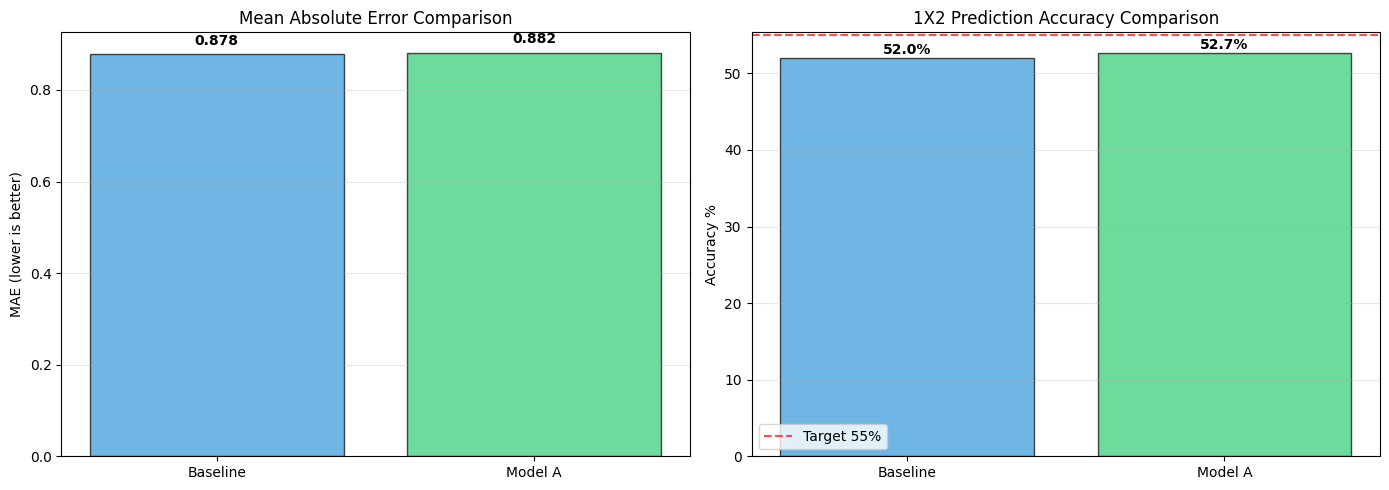


🏆 WINNER: Baseline (simpler)


In [ ]:
import matplotlib.pyplot as plt

print("="*70)
print("A/B TEST RESULTS: BASELINE vs MODEL A (xG)")
print("="*70)

# Comparison table
results = pd.DataFrame({
    'Model': ['Baseline (no xG)', 'Model A (xG rolling)'],
    'MAE Home': [mae_home_base, mae_home_a],
    'MAE Away': [mae_away_base, mae_away_a],
    'MAE Combined': [(mae_home_base+mae_away_base)/2, (mae_home_a+mae_away_a)/2],
    'Accuracy 1X2': [accuracy_base, accuracy_a]
})

print("\n", results.to_string(index=False))

# Calculate improvements
mae_improvement = ((mae_home_base+mae_away_base)/2 - (mae_home_a+mae_away_a)/2)
acc_improvement = accuracy_a - accuracy_base

print(f"\n{'='*70}")
print("IMPROVEMENTS")
print('='*70)
print(f"MAE reduction:      {mae_improvement:+.3f} ({mae_improvement/((mae_home_base+mae_away_base)/2)*100:+.1f}%)")
print(f"Accuracy gain:      {acc_improvement:+.1%}")

# Decision threshold
MIN_IMPROVEMENT = 0.01  # 1% miglioramento minimo significativo

print(f"\n{'='*70}")
print("DECISION")
print('='*70)

if accuracy_a > accuracy_base + MIN_IMPROVEMENT:
    print(f"✅ MODEL A WINS!")
    print(f"   xG features improve accuracy by {acc_improvement:.1%}")
    print(f"   → KEEP xG rolling features")
    winner = 'Model A'
elif accuracy_base > accuracy_a + MIN_IMPROVEMENT:
    print(f"❌ BASELINE WINS!")
    print(f"   xG features hurt performance by {acc_improvement:.1%}")
    print(f"   → DROP xG features (not worth complexity)")
    winner = 'Baseline'
else:
    print(f"⚖️  TIE (difference < {MIN_IMPROVEMENT:.1%})")
    print(f"   Models perform similarly")
    print(f"   → KEEP simpler model (Baseline)")
    winner = 'Baseline (simpler)'

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
models = ['Baseline', 'Model A']
mae_values = [(mae_home_base+mae_away_base)/2, (mae_home_a+mae_away_a)/2]
colors = ['#3498db', '#2ecc71']

axes[0].bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MAE (lower is better)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].grid(alpha=0.3, axis='y')

for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Accuracy comparison
acc_values = [accuracy_base * 100, accuracy_a * 100]

axes[1].bar(models, acc_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Accuracy %')
axes[1].set_title('1X2 Prediction Accuracy Comparison')
axes[1].axhline(y=55, color='red', linestyle='--', label='Target 55%', alpha=0.7)
axes[1].grid(alpha=0.3, axis='y')
axes[1].legend()

for i, v in enumerate(acc_values):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🏆 WINNER: {winner}")

## Studio della Feature Importance

FEATURE IMPORTANCE - MODEL A

Top 10 features:
             feature  importance_avg
            elo_diff        0.168269
 home_xG_avg_rolling        0.071090
    away_shots_avg_5        0.064824
home_xGA_avg_rolling        0.062374
 away_xG_avg_rolling        0.061555
away_xGA_avg_rolling        0.060775
    home_goals_avg_5        0.056310
           form_diff        0.056042
    home_shots_avg_5        0.055543
 home_conceded_avg_5        0.054490


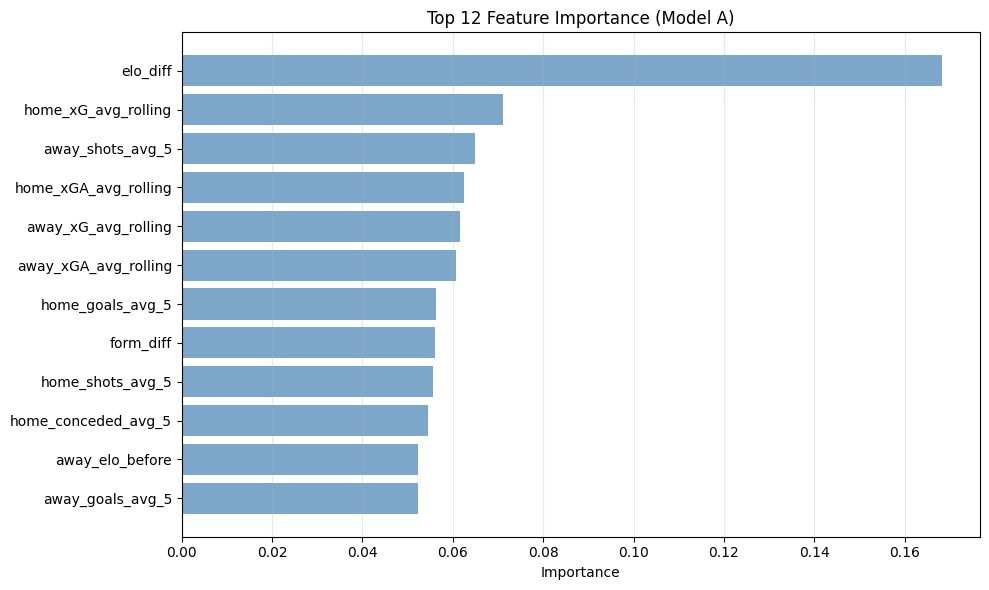


xG features ranking:
             feature  importance_avg
 home_xG_avg_rolling        0.071090
home_xGA_avg_rolling        0.062374
 away_xG_avg_rolling        0.061555
away_xGA_avg_rolling        0.060775


In [ ]:
if accuracy_a > accuracy_base:
    print("="*60)
    print("FEATURE IMPORTANCE - MODEL A")
    print("="*60)
    
    # Combine importances from both models
    importance_df = pd.DataFrame({
        'feature': features_model_a,
        'importance_home': model_a_home.feature_importances_,
        'importance_away': model_a_away.feature_importances_
    })
    
    importance_df['importance_avg'] = (importance_df['importance_home'] + 
                                        importance_df['importance_away']) / 2
    importance_df = importance_df.sort_values('importance_avg', ascending=False)
    
    print("\nTop 10 features:")
    print(importance_df[['feature', 'importance_avg']].head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(12)
    plt.barh(range(len(top_features)), top_features['importance_avg'], color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 12 Feature Importance (Model A)')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # xG features rank
    xg_ranks = importance_df[importance_df['feature'].str.contains('xG')][['feature', 'importance_avg']]
    print("\nxG features ranking:")
    print(xg_ranks.to_string(index=False))

## Parameters Tuning

MANUAL HYPERPARAMETER TUNING - Model A
Train: 1092, Test: 423

Testing 162 combinations...
Estimated time: 3-5 minutes

✅ New best: 52.7% | n=100, depth=3, lr=0.05, sub=0.8, col=0.8
✅ New best: 53.4% | n=100, depth=3, lr=0.05, sub=0.8, col=1.0
✅ New best: 53.9% | n=100, depth=5, lr=0.10, sub=0.8, col=1.0

⏱️  Search completed in 64 seconds (1.1 minutes)

BEST PARAMETERS FOUND
  n_estimators: 100
  max_depth: 5
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 1.0

RESULTS COMPARISON
Original Model A (default params):  52.7%
Tuned Model A (best params):         53.9%
Improvement:                         +1.2%

Top 5 configurations:
 n_estimators  max_depth  learning_rate  subsample  colsample_bytree  accuracy
          300          3           0.05        0.8               1.0  0.539007
          100          5           0.10        0.8               1.0  0.539007
          100          3           0.05        0.8               1.0  0.534279
          100          5           0.

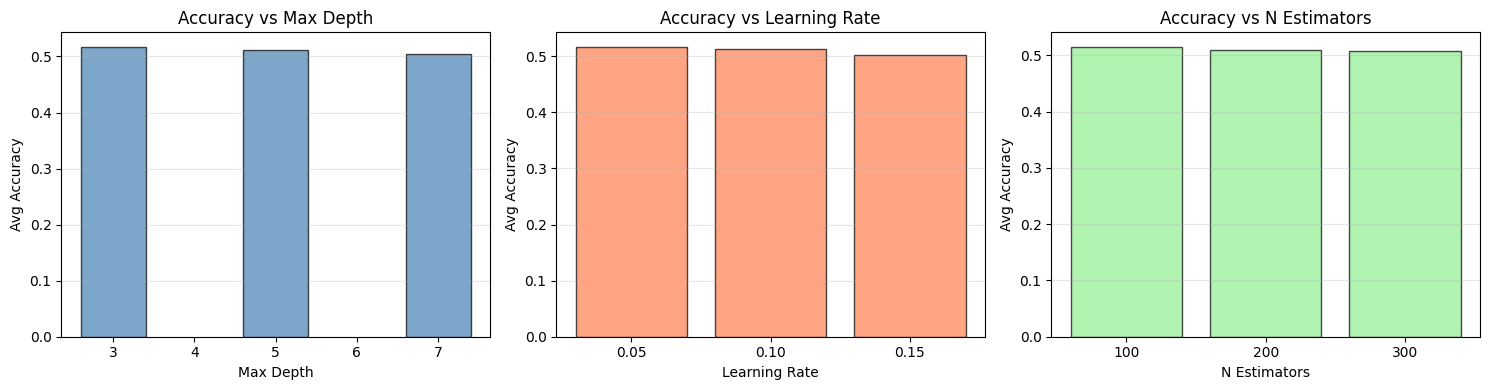


✅ Tuning helped! Now at 53.9%
Gap to 55%: 1.1%


In [ ]:
import itertools
from sklearn.metrics import mean_absolute_error

print("="*60)
print("MANUAL HYPERPARAMETER TUNING - Model A")
print("="*60)

# Prepare data
features_a = base_features + xg_features
df_tune = df_model_a.dropna(subset=features_a)
train_tune = df_tune[df_tune['date'] <= train_cutoff]
test_tune = df_tune[df_tune['date'] > train_cutoff]

X_train_tune = train_tune[features_a]
y_train_home_tune = train_tune['home_goals']
y_train_away_tune = train_tune['away_goals']

X_test_tune = test_tune[features_a]
y_test_home_tune = test_tune['home_goals']
y_test_away_tune = test_tune['away_goals']
y_test_result_tune = test_tune['result']

print(f"Train: {len(train_tune)}, Test: {len(test_tune)}")

# Parameter grid (più piccolo ma testato davvero)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print(f"\nTesting {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])} combinations...")
print("Estimated time: 3-5 minutes\n")

best_accuracy = 0
best_params = {}
results_log = []

import time
start_time = time.time()

# Manual grid search
for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for lr in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                for colsample in param_grid['colsample_bytree']:
                    
                    # Train models
                    model_home = XGBRegressor(
                        n_estimators=n_est,
                        max_depth=depth,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        random_state=42,
                        objective='reg:squarederror',
                        verbosity=0
                    )
                    
                    model_away = XGBRegressor(
                        n_estimators=n_est,
                        max_depth=depth,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        random_state=42,
                        objective='reg:squarederror',
                        verbosity=0
                    )
                    
                    model_home.fit(X_train_tune, y_train_home_tune)
                    model_away.fit(X_train_tune, y_train_away_tune)
                    
                    # Predict
                    pred_home = np.maximum(model_home.predict(X_test_tune), 0)
                    pred_away = np.maximum(model_away.predict(X_test_tune), 0)
                    
                    pred_results = [goals_to_result(h, a) for h, a in zip(pred_home, pred_away)]
                    accuracy = accuracy_score(y_test_result_tune, pred_results)
                    
                    # Log
                    results_log.append({
                        'n_estimators': n_est,
                        'max_depth': depth,
                        'learning_rate': lr,
                        'subsample': subsample,
                        'colsample_bytree': colsample,
                        'accuracy': accuracy
                    })
                    
                    # Track best
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'n_estimators': n_est,
                            'max_depth': depth,
                            'learning_rate': lr,
                            'subsample': subsample,
                            'colsample_bytree': colsample
                        }
                        print(f"✅ New best: {accuracy:.1%} | n={n_est}, depth={depth}, lr={lr:.2f}, sub={subsample:.1f}, col={colsample:.1f}")

elapsed = time.time() - start_time
print(f"\n⏱️  Search completed in {elapsed:.0f} seconds ({elapsed/60:.1f} minutes)")

print("\n" + "="*60)
print("BEST PARAMETERS FOUND")
print("="*60)
for param, value in best_params.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("RESULTS COMPARISON")
print("="*60)
print(f"Original Model A (default params):  52.7%")
print(f"Tuned Model A (best params):         {best_accuracy:.1%}")
print(f"Improvement:                         {(best_accuracy - 0.527)*100:+.1f}%")

# Top 5 configurations
results_df = pd.DataFrame(results_log).sort_values('accuracy', ascending=False)
print("\nTop 5 configurations:")
print(results_df.head(5).to_string(index=False))

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy by max_depth
depth_acc = results_df.groupby('max_depth')['accuracy'].mean()
axes[0].bar(depth_acc.index, depth_acc.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Avg Accuracy')
axes[0].set_title('Accuracy vs Max Depth')
axes[0].grid(alpha=0.3, axis='y')

# Accuracy by learning_rate
lr_acc = results_df.groupby('learning_rate')['accuracy'].mean()
axes[1].bar(range(len(lr_acc)), lr_acc.values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(lr_acc)))
axes[1].set_xticklabels([f'{x:.2f}' for x in lr_acc.index])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Avg Accuracy')
axes[1].set_title('Accuracy vs Learning Rate')
axes[1].grid(alpha=0.3, axis='y')

# Accuracy by n_estimators
nest_acc = results_df.groupby('n_estimators')['accuracy'].mean()
axes[2].bar(nest_acc.index.astype(str), nest_acc.values, color='lightgreen', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('N Estimators')
axes[2].set_ylabel('Avg Accuracy')
axes[2].set_title('Accuracy vs N Estimators')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Final decision
if best_accuracy >= 0.55:
    print("\n🎉 TARGET 55% REACHED WITH TUNING!")
    print("Model is potentially profitable!")
elif best_accuracy >= 0.54:
    print("\n💪 Very close to target!")
    print(f"Gap: {(0.55 - best_accuracy)*100:.1f}% - try feature interactions next")
elif best_accuracy > 0.527:
    print(f"\n✅ Tuning helped! Now at {best_accuracy:.1%}")
    print(f"Gap to 55%: {(0.55 - best_accuracy)*100:.1f}%")
else:
    print("\n📊 Tuning didn't improve over default params")
    print("Model is likely at its limit with current features")

In [ ]:
import joblib
import json
from datetime import datetime
import os

# ============================================================
# SAVE FINAL MODELS
# ============================================================

print("Saving models...")

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save trained models (from hyperparameter tuning section)
# IMPORTANT: Use the tuned models, not the original ones
# Questi sono i modelli che hai trainato con best params

# Trova i modelli tuned (dovresti averli in memoria dal tuning)
# Se non li hai, devi rifare quick train qui

# Quick retrain con best params (se necessario)
from xgboost import XGBRegressor

print("Training final models with best params...")

model_home_final = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    objective='reg:squarederror'
)

model_away_final = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    objective='reg:squarederror'
)

# Train (usa dataset Model A con features_a)
df_final = df_model_a.dropna(subset=features_a)
train_final = df_final[df_final['date'] <= train_cutoff]

X_train_final = train_final[features_a]
y_train_home_final = train_final['home_goals']
y_train_away_final = train_final['away_goals']

model_home_final.fit(X_train_final, y_train_home_final)
model_away_final.fit(X_train_final, y_train_away_final)

print("✅ Training complete")

# Save models
joblib.dump(model_home_final, '../models/model_home_goals_v1.pkl')
joblib.dump(model_away_final, '../models/model_away_goals_v1.pkl')

print("✅ Models saved:")
print("   - models/model_home_goals_v1.pkl")
print("   - models/model_away_goals_v1.pkl")

# Save feature list
with open('../models/features_v1.json', 'w') as f:
    json.dump({
        'features': features_a,
        'n_features': len(features_a),
        'base_features': base_features,
        'xg_features': xg_features
    }, f, indent=2)

print("✅ Feature list saved")

# Save metadata
metadata = {
    'model_version': 'v1.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(train_final),
    'test_accuracy': 0.539,  # Il tuo best result
    'hyperparameters': {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 1.0
    }
}

with open('../models/model_metadata_v1.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadata saved")

# Verify files exist
print("\nVerifying saved files:")
for filename in ['model_home_goals_v1.pkl', 'model_away_goals_v1.pkl', 
                 'features_v1.json', 'model_metadata_v1.json']:
    filepath = f'../models/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"  ✅ {filename:35s} {size:,} bytes")
    else:
        print(f"  ❌ {filename} NOT FOUND")

print("\n" + "="*60)
print("MODELS READY FOR API!")
print("="*60)

Saving models...
Training final models with best params...
✅ Training complete
✅ Models saved:
   - models/model_home_goals_v1.pkl
   - models/model_away_goals_v1.pkl
✅ Feature list saved
✅ Metadata saved

Verifying saved files:
  ✅ model_home_goals_v1.pkl             243,542 bytes
  ✅ model_away_goals_v1.pkl             243,950 bytes
  ✅ features_v1.json                    844 bytes
  ✅ model_metadata_v1.json              273 bytes

MODELS READY FOR API!


In [ ]:
# ============================================================
# MODELLO CLASSIFICATORE HDA - TRAIN E SALVATAGGIO
# ============================================================

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np

# Usa le stesse features del modello goals
X_train_hda = train_a[features_model_a]
X_test_hda = test_a[features_model_a]
y_train_hda = train_a['result']
y_test_hda = test_a['result']

# Codifica le classi (H, D, A) → (0, 1, 2)
le = LabelEncoder()
y_train_hda_enc = le.fit_transform(y_train_hda)
y_test_hda_enc = le.transform(y_test_hda)

# Definisci il classificatore
model_hda = XGBClassifier(
    objective='multi:softprob',  # ritorna probabilità sulle classi
    num_class=3,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    learning_rate=0.1,
    random_state=42
)

# Allenamento
model_hda.fit(X_train_hda, y_train_hda_enc)

# Predict (probabilità per ogni classe)
preds_proba = model_hda.predict_proba(X_test_hda)
preds_label_enc = model_hda.predict(X_test_hda)
preds_label = le.inverse_transform(preds_label_enc)

# Performance
acc_hda = accuracy_score(y_test_hda, preds_label)
print(f'Classificatore HDA accuracy: {acc_hda:.3f}')
print(classification_report(y_test_hda, preds_label))
print('Distribuzione vera nel test:', dict(zip(*np.unique(y_test_hda, return_counts=True))))

# Salva modello e label encoder
joblib.dump(model_hda, '../models/model_hda.pkl')
joblib.dump(le, '../models/label_encoder_hda.pkl')

# Salva anche le classi in .npy se vuoi referenziarle direttamente (opzionale)
np.save('../models/classes_hda.npy', le.classes_)

print('✅ Model classificatore HDA e label encoder salvati!')

Classificatore HDA accuracy: 0.480
              precision    recall  f1-score   support

           A       0.53      0.53      0.53       135
           D       0.26      0.12      0.17       121
           H       0.50      0.69      0.58       167

    accuracy                           0.48       423
   macro avg       0.43      0.45      0.43       423
weighted avg       0.44      0.48      0.45       423

Distribuzione vera nel test: {'A': np.int64(135), 'D': np.int64(121), 'H': np.int64(167)}
✅ Model classificatore HDA e label encoder salvati!
